In [1]:
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


In [2]:
!pip install graphviz xgboost


In [3]:
!pip install shap

In [4]:
!conda install python-graphviz --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



In [5]:
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.1.3


In [6]:
import graphviz
import xgboost as xgb
import shap
shap.initjs()

In [7]:
plt.rcParams["figure.figsize"] = (8, 6)
plt.rc_context({'axes.edgecolor':'#cacaca', 'xtick.color':'#cacaca', 'ytick.color':'#cacaca', 'axes.labelcolor' :'#cacaca', 'text.color' :'#cacaca'})
sns.set_palette(sns.color_palette("OrRd", 10))

In [8]:
df_users = pd.read_csv("../data/user.csv")
df_jobs = pd.read_csv("../data/job_desc.csv")

print(df_users.shape)
print(df_jobs.shape)

(2000, 58)
(2000, 4)


In [9]:
usercolumns = df_users.columns

In [10]:
df_joined = pd.merge(df_users, df_jobs, on='user_id')

In [11]:
df_joined.columns

Index(['user_id', 'has_applied', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14',
       'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23',
       'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v30', 'v31', 'v32',
       'v33', 'v34', 'v35', 'v36', 'v37', 'v38', 'v39', 'v4', 'v40', 'v41',
       'v42', 'v43', 'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v5', 'v50',
       'v51', 'v52', 'v53', 'v54', 'v55', 'v56', 'v6', 'v7', 'v8', 'v9',
       'job_title_full', 'salary', 'company'],
      dtype='object')

In [12]:
df_joined.shape

(2000, 61)

In [13]:
df_joined['has_applied'].describe()

count    2000.000000
mean        0.576000
std         0.494314
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: has_applied, dtype: float64

In [14]:
df_joined['salary'].describe()

count      613.000000
mean     59980.424144
std       5912.455708
min      50000.000000
25%      55000.000000
50%      60000.000000
75%      65000.000000
max      70000.000000
Name: salary, dtype: float64

Missing a lot of salaries. NA's interesting

In [15]:
df_joined['has_salary'] = ~df_joined['salary'].isna()
df_joined['has_salary'].describe()

count      2000
unique        2
top       False
freq       1387
Name: has_salary, dtype: object

In [16]:
df_joined.isnull().sum().sort_values(ascending=False).head(20)

v25       1414
salary    1387
v30       1378
v32         52
v34         51
v15         50
v17         50
v20         49
v12         49
v19         49
v11         48
v18         48
v50         48
v6          47
v10         46
v3          46
v55         46
v40         45
v39         44
v54         44
dtype: int64

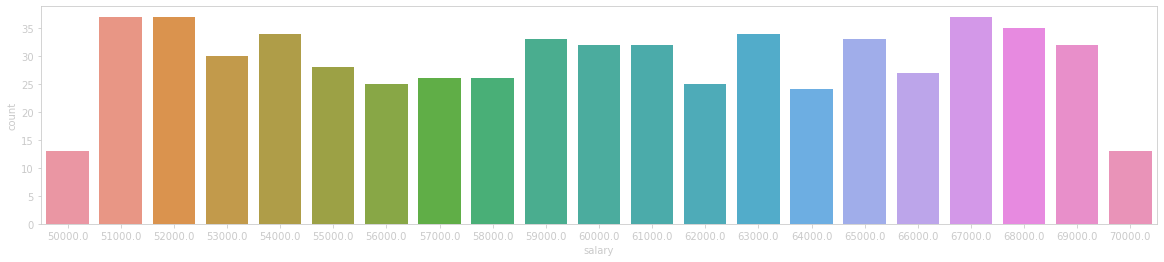

In [17]:
fig_dims = (20,4)
fig, ax = plt.subplots(figsize=fig_dims)

sns.countplot(x=df_joined["salary"], ax = ax)
plt.savefig('demo.png', transparent=True)

In [18]:
df_joined['company'].describe()

count     2000
unique       8
top          d
freq       287
Name: company, dtype: object

In [19]:
df_joined['company'] = pd.Categorical(df_joined['company'])
df_joined['company'].describe()

count     2000
unique       8
top          d
freq       287
Name: company, dtype: object

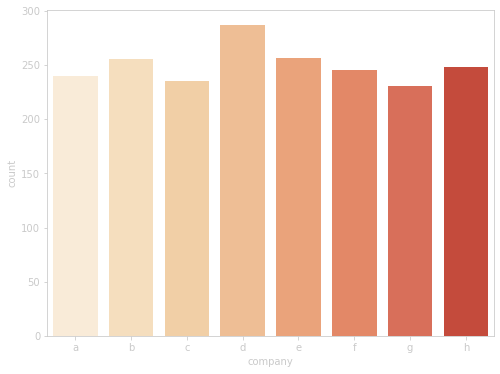

In [20]:
sns.countplot(x=df_joined["company"])


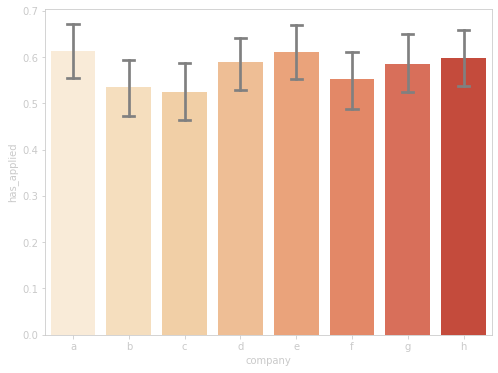

In [21]:
sns.barplot(x=df_joined["company"], y=df_joined["has_applied"], capsize=.2, errcolor='grey')
plt.savefig('companies.svg', transparent=True)

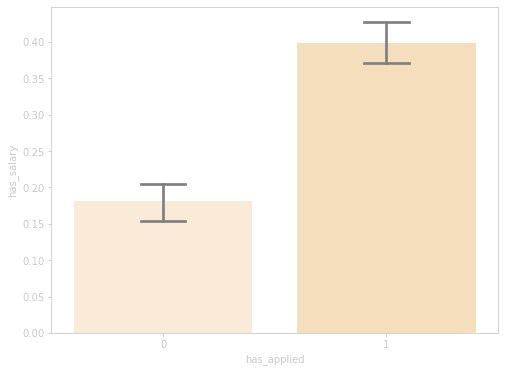

In [22]:
sns.barplot(x=df_joined["has_applied"], y=df_joined["has_salary"], capsize=.2, errcolor='grey')
plt.savefig('has_salary.svg', transparent=True)

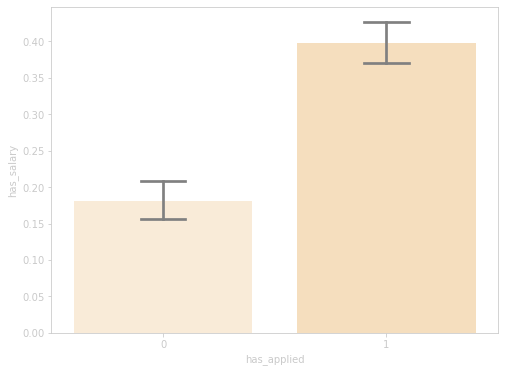

In [23]:
sns.barplot(x=df_joined["has_applied"], y=df_joined["has_salary"], capsize=.2, errcolor='grey')
plt.savefig('has_salary.svg', transparent=True)

In [24]:
pd.crosstab(df_joined['has_applied'], df_joined['has_salary'])

has_salary   False  True 
has_applied              
0              694    154
1              693    459

In [25]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    return(chi2_contingency(ctsum.fillna(0)))

chisq_of_df_cols(df_joined, 'has_applied', 'has_salary')

(107.02489902565313,
 4.396113707692454e-25,
 1,
 array([[588.088, 798.912],
        [259.912, 353.088]]))

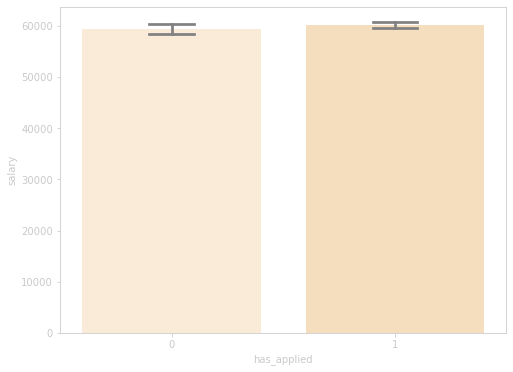

In [26]:
sns.barplot(x=df_joined["has_applied"], y=df_joined["salary"], capsize=.2, errcolor='grey')
plt.savefig('salary.svg', transparent=True)

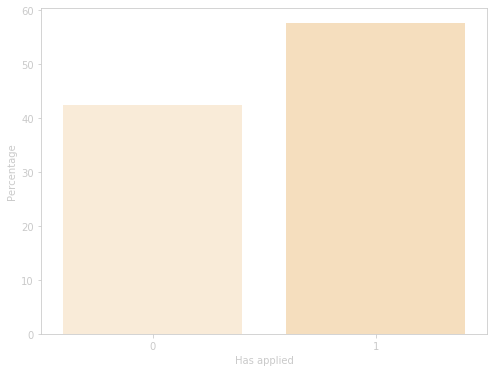

In [27]:
tmp_data = df_joined['has_applied'].value_counts(normalize=True).rename('percentage').mul(100).reset_index().rename(columns={"index": "Has applied", "percentage": "Percentage"})
tmp_data
p = sns.barplot(x="Has applied", y="Percentage", data=tmp_data)
plt.savefig('has_applied.svg', transparent=True)

In [28]:
df_joined.groupby('company')['has_applied'].agg([np.size, np.mean, np.sum]).sort_values(by="mean", ascending=False)

size      mean  sum
company                     
a         240  0.612500  147
e         257  0.610895  157
h         248  0.596774  148
d         287  0.588850  169
g         231  0.584416  135
f         246  0.552846  136
b         256  0.535156  137
c         235  0.523404  123

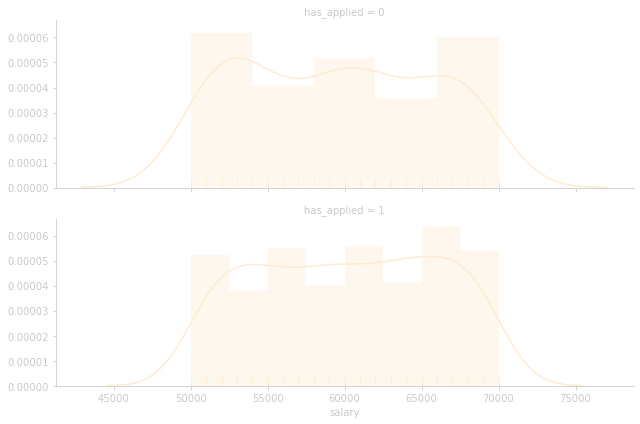

In [29]:
applied = df_joined[df_joined['has_applied'] == 1]
#sns.distplot(applied['salary'].dropna())

g = sns.FacetGrid(df_joined, row="has_applied",
                   aspect=3, dropna=True)
g.map(sns.distplot, "salary", hist=True, rug=True);
plt.savefig('histogram_stacked.svg', transparent=True)

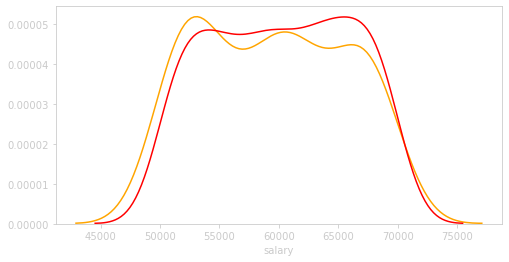

In [30]:
plt.rcParams["figure.figsize"] = (8, 4)
not_applied = df_joined[df_joined['has_applied'] == 0]
sns.distplot(not_applied['salary'].dropna(),color='orange', hist=False)
sns.distplot(applied['salary'].dropna(),color='red',hist=False)
plt.savefig('histogram_hue.svg', transparent=True)

plt.rcParams["figure.figsize"] = (8, 6)

In [31]:
scipy.stats.levene(applied['salary'].dropna(), not_applied['salary'].dropna(), center='median')

LeveneResult(statistic=0.5829520650134441, pvalue=0.44545223484386287)

In [32]:
scipy.stats.ttest_ind(applied['salary'].dropna(), not_applied['salary'].dropna())

Ttest_indResult(statistic=1.2604182228246374, pvalue=0.20799966516827847)

In [33]:
def clean (dataframe):
    # get rid of user ids, if they matter, the model is overfit
    new_df = dataframe.loc[:, dataframe.columns != 'user_id']
    # encode variables
    encoder = OneHotEncoder()
    enc_df = pd.DataFrame(encoder.fit_transform(new_df[['company']]).toarray())
    #df_joined.columns[df_joined.columns.duplicated()]
    new_df = new_df.join(enc_df)
    new_df = new_df.loc[:, new_df.columns != 'company']
    new_df.rename(columns = {0 : 'company_a', 1 : 'company_b', 2 : 'company_c', 3 : 'company_d', 4 : 'company_e', 5 : 'company_f', 6 : 'company_g', 7 : 'company_h', 8 : 'company_i'}, inplace = True)
    labelencoder = LabelEncoder()
    new_df['has_salary'] = labelencoder.fit_transform(new_df['has_salary'])
    
   # new_df['salary'] = new_df['salary'].fillna(-1)
    
    new_df['has_mfd'] = new_df['job_title_full'].apply(lambda x: "m/f/d" in x.lower())
    new_df['has_mfd'] = labelencoder.fit_transform(new_df['has_mfd'])
    
    new_df['count_spaces'] = new_df['job_title_full'].apply(lambda x: x.count(" "))
    #new_df['count_periods'] = new_df['job_title_full'].apply(lambda x: x.count("."))
    #new_df['count_exclamation'] = new_df['job_title_full'].apply(lambda x: x.count("!"))
    #new_df['count_question'] = new_df['job_title_full'].apply(lambda x: x.count("?"))
    new_df['avg_word_length'] = new_df['job_title_full'].apply(lambda x: len(x) / (x.count(" ") +1))
    new_df['avg_sentence_length'] = new_df['job_title_full'].apply(lambda x: x.count(" ") / (x.count(".") +1))
    new_df['count_digits'] = new_df['job_title_full'].apply(lambda x: len(re.findall("d", x)))
    new_df['count_slashes'] = new_df['job_title_full'].apply(lambda x: x.count("/"))
    new_df['count_paren'] = new_df['job_title_full'].apply(lambda x: x.count("("))
    
    
   #new_df = impute_simple(new_df)
    return new_df

def impute_simple(data):
    data_without_title = data.loc[:, data.columns != 'job_title_full']
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    imputed = pd.DataFrame(imp.fit_transform(data_without_title))
    imputed.columns = data_without_title.columns
    return imputed.join(data['job_title_full'])

def impute_complex(data):
    data_without_title = data.loc[:, data.columns != 'job_title_full']
    imp = IterativeImputer(missing_values=np.nan, random_state=23)
    
    imputed = pd.DataFrame(imp.fit_transform(data_without_title))
    imputed.columns = data_without_title.columns
    return imputed.join(data['job_title_full'])

In [34]:
df_cleaned = clean(df_joined)


In [35]:
df_cleaned.isnull().sum().sort_values(ascending=False)

v25               1414
salary            1387
v30               1378
v32                 52
v34                 51
                  ... 
company_a            0
has_salary           0
job_title_full       0
v53                  0
has_applied          0
Length: 75, dtype: int64

In [36]:
df_cleaned.isnull().sum().sum()

6228

In [37]:
df_cleaned['char_length_title'] = df_cleaned['job_title_full'].apply(lambda x: len(x))


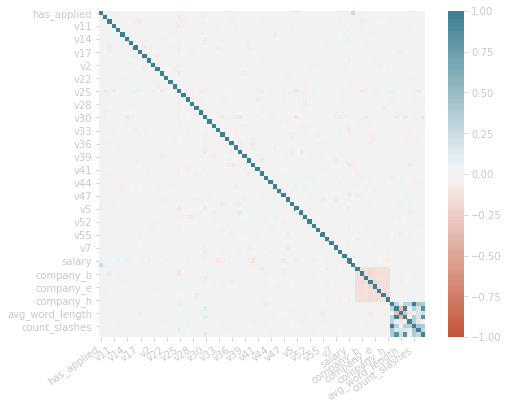

In [38]:
corr_matrix = df_cleaned.corr()

ax = sns.heatmap(
    corr_matrix, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=35,
    horizontalalignment='right'
);

plt.savefig('correlations.svg', transparent=True)

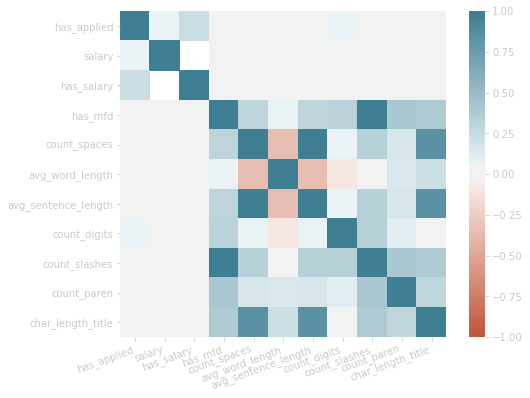

In [39]:
df_corr = df_cleaned.loc[:, ~df_cleaned.columns.str.startswith('v')]
df_corr = df_corr.loc[:, ~df_corr.columns.str.startswith('company')]

corr = df_corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=20,
    horizontalalignment='right'
);

plt.savefig('correlations2.svg', transparent=True)

In [40]:
df_cleaned['has_mfd'].value_counts(normalize=True)

0    0.5545
1    0.4455
Name: has_mfd, dtype: float64

In [41]:
df_cleaned.groupby('has_mfd').count()

has_applied    v1   v10   v11   v12   v13   v14   v15   v16   v17  \
has_mfd                                                                      
0               1109  1094  1081  1083  1079  1090  1089  1081  1086  1088   
1                891   879   873   869   872   872   869   869   870   862   

         ...  company_f  company_g  company_h  count_spaces  avg_word_length  \
has_mfd  ...                                                                   
0        ...       1109       1109       1109          1109             1109   
1        ...        891        891        891           891              891   

         avg_sentence_length  count_digits  count_slashes  count_paren  \
has_mfd                                                                  
0                       1109          1109           1109         1109   
1                        891           891            891          891   

         char_length_title  
has_mfd                     
0                     1109  
1                      891  

[2 rows x 75 columns]

In [42]:
df_cleaned['job_title_full'].unique(), df_cleaned['job_title_full'].unique().shape

(array(['Junior Manager Innovation Lab - France (M/F/D)',
        'Junior Product Manager -  Mobile',
        'Junior Brand Marketing Manager - Mobile (M/F/D)',
        ' Product Analyst - Pricing & Forecasting (M/F/D)',
        ' Online Marketing Manager', ' Marketing Analyst - New Ventures ',
        'Lead Growth Hacker - New Ventures ',
        'Senior Sustainability Manager',
        'Lead Data Analyst - Pricing Team (m/f/d)',
        'Senior Product Owner - NLP',
        'Lead Backend Engineer - Deep Learning',
        'Junior UI Designer - (Remote)',
        ' Marketing Manager - (Remote) m/f/d',
        'Lead Data Consultant - Supplier Financing m/f/d',
        ' Brand Marketing Manager - (Remote)',
        ' SEO Marketing Manager m/f/d',
        'Senior Marketing Manager - New Ventures ',
        'Senior Growth Marketing Manager - (Remote)',
        'Junior Operations Manager - New Ventures',
        'Senior AI Researcher - NLP m/f/d',
        'Junior Marketing Manager - New Ve

In [43]:
!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS
wordcloud = WordCloud(background_color="rgba(255, 255, 255, 0)", mode="RGBA", stopwords = STOPWORDS,
                max_words = 200, max_font_size = 100, 
                random_state = 17, width=800, height=400)

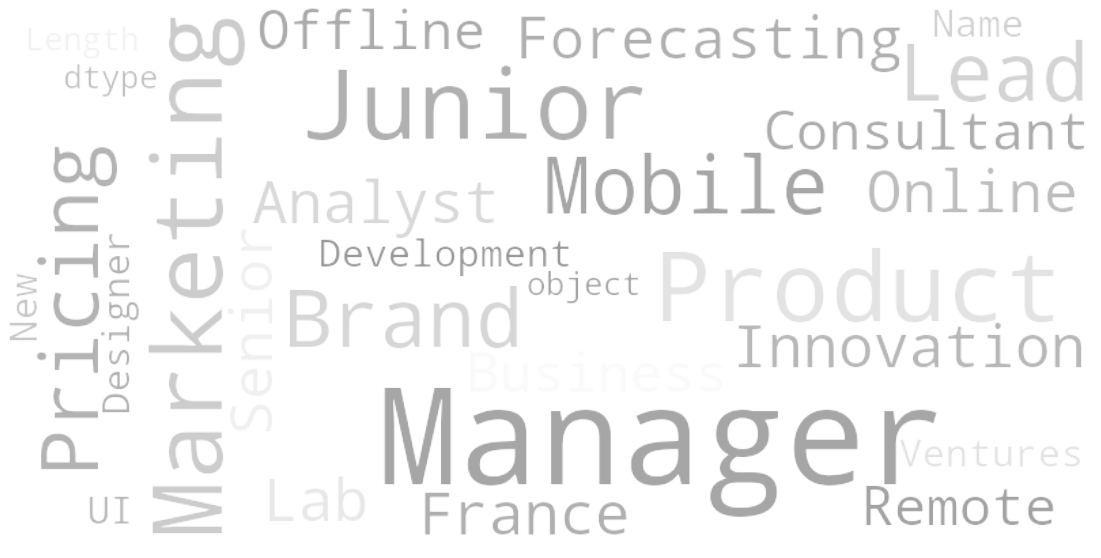

In [44]:
wordcloud.generate(str(df_cleaned.loc[df_cleaned['has_applied'] ==1, 'job_title_full']))
plt.figure(figsize=(20,10))
import random
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=23),
           interpolation="bilinear");
plt.axis("off")

plt.savefig('wordcloud.svg', transparent=True)

In [45]:
vec = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=2)
vectorized = vec.fit_transform(df_cleaned['job_title_full'])


df_vectorized = pd.DataFrame(vectorized.todense(), columns= vec.get_feature_names())

df_combined = df_vectorized.join(df_cleaned.loc[:, df_cleaned.columns != 'job_title_full'])

In [46]:
df_combined.groupby('has_applied').sum()

affairs  affairs apac  affairs france  affairs new  \
has_applied                                                        
0            8.648645      3.418441         5.61179     1.377782   
1            7.835148      1.709221         5.28569     2.411118   

             affairs new ventures        ai  ai researcher  \
has_applied                                                  
0                        1.377782  7.453250       7.453250   
1                        2.411118  9.681557       9.681557   

             ai researcher deep  ai researcher nlp  ai researcher pricing  \
has_applied                                                                 
0                      1.716500           2.766276               2.775464   
1                      4.462899           3.556640               2.428531   

             ...  company_g  company_h  has_mfd  count_spaces  \
has_applied  ...                                                
0            ...       96.0      100.0      370          4288   
1            ...      135.0      148.0      521          5862   

             avg_word_length  avg_sentence_length  count_digits  \
has_applied                                                       
0                5264.540873               4288.0           600   
1                7074.096429               5862.0           898   

             count_slashes  count_paren  char_length_title  
has_applied                                                 
0                      749          359              31502  
1                     1088          504              42594  

[2 rows x 541 columns]

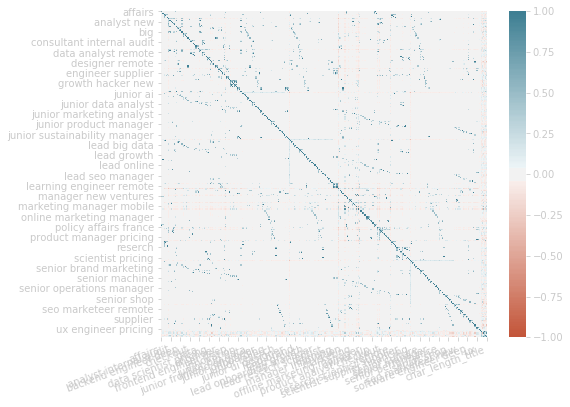

In [47]:
df_corr = df_combined.loc[:, ~df_combined.columns.str.startswith('v')]
df_corr = df_corr.loc[:, ~df_corr.columns.str.startswith('company')]

corr = df_corr.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=20,
    horizontalalignment='right'
);
plt.savefig('correlations3.png', transparent=True)

In [48]:
corr[['has_applied']].sort_values('has_applied', ascending = False).head(5)

has_applied
has_applied             1.000000
has_salary              0.232425
product                 0.152532
product analyst         0.097112
product ux engineer     0.086601

In [49]:
corr[['has_applied']].sort_values('has_applied', ascending = True).head(5)

has_applied
machine learning engineer    -0.059839
machine learning             -0.059839
machine                      -0.059839
learning engineer            -0.059839
analyst remote               -0.051544

In [115]:
def split(data):
    df_X = data.loc[:, data.columns != 'has_applied']
    df_X = df_X.loc[:, df_X.columns != 'job_title_full']
    df_y = data.loc[:, 'has_applied']

    df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_X, df_y, test_size=0.25, random_state=23)    
    return df_X_train, df_X_test, df_y_train, df_y_test
X_train, X_test, y_train, y_test = split(df_combined)

In [51]:
def split_simple(data):
    df_X = data.loc[:, data.columns != 'has_applied']
    df_X = df_X.loc[:, df_X.columns != 'job_title_full']
    df_y = data.loc[:, 'has_applied']

    return df_X, df_y
X, y = split_simple(df_combined)

In [52]:
def logistic_regression(X_train, y_train, X_test, y_test):
#selector = SequentialFeatureSelector(LogisticRegression(),
#              k_features=50,
#              forward=True,
#              floating=False,
#              verbose=2,
#              scoring='r2',
#              cv=3)

#selector.fit(X_train, y_train)
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=23)
    roc_auc_weighted = make_scorer(roc_auc_score, needs_proba=True)

    c_values = np.logspace(-2, 3, 500)

    logit_searcher = LogisticRegressionCV(
        Cs=c_values, 
        cv=skf, 
        verbose=1, 
        n_jobs=-1, 
        scoring='roc_auc', 
        random_state=23,
        fit_intercept=True,
        tol = 10e-4
    )
    logit_searcher.fit(X_train, y_train)
    
    
    #plt.plot(c_values, np.mean(logit_searcher.scores_[1], axis=0))
    #plt.xlabel('C')
    #plt.ylabel('Mean CV-accuracy')
    
    #logit_searcher.scores_[1].mean(axis=0).max()
    #coefficients = pd.concat([pd.DataFrame(X_train.columns), pd.DataFrame(np.transpose(logit_searcher.coef_))], axis = 1)

    #coefficients.columns = ['feature', 'coefficient']
    #coefficients.sort_values(by='coefficient',ascending = False)
    
    #result = logit_searcher.predict(X_test)
    #fpr, tpr, thresholds = metrics.roc_curve(y_test, result)
    return metrics.auc(fpr, tpr)
#logistic_regression(X_train, y_train, X_test, y_test)

In [53]:
%%time
from sklearn import tree
def random_forest(X_train, y_train, X_test, y_test):
    rf = RandomForestClassifier(n_jobs=-1, random_state=23, 
                                class_weight='balanced')
    parameters = {'max_features': [100, 200], 'n_estimators': [100, 300, 500], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5,10,15]}


    rf_grid_search = GridSearchCV(rf, parameters, n_jobs=-1, scoring='roc_auc', cv=skf, verbose=True)
    rf_grid_search = rf_grid_search.fit(X_train, y_train)
    print(rf_grid_search.best_score_)
    result = rf_grid_search.predict(X_test)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, result)
    retval = metrics.auc(fpr, tpr)
    
    print(rf_grid_search.best_params_)
        
   # plt.figure(figsize=(50,50))
    #tree.plot_tree(rf_grid_search.best_estimator_.estimators_[0], filled=True, feature_names=df_combined.columns, 
    #              class_names=['Y', 'N'], node_ids=True);

    return retval
#random_forest(X_train, y_train, X_test, y_test)

CPU times: user 20 µs, sys: 2 µs, total: 22 µs
Wall time: 1.26 ms


dtrain = xgb.DMatrix(X_train, label=y_train)
dtrain.save_binary('train.buffer')

In [54]:
%%time

## Learning on subset of data
param_test = {
# 'max_depth':[4,5,6],
# 'min_child_weight':[4,5,6,8],
# 'gamma':[i/10.0 for i in range(0,5)],
# 'subsample':[i/10.0 for i in range(6,10)],
# 'colsample_bytree':[i/10.0 for i in range(6,10)]
    'n_estimators':[140, 150, 160],
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( 
        learning_rate = 0.1,
        n_estimators=120,
        max_depth=6,
        min_child_weight=8,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.9,
        objective = 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 0.1,
        seed=23),
       param_grid = param_test, scoring='roc_auc',n_jobs=4,verbose=10, cv=5)
gsearch4.fit(X_train, y_train)
gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   24.1s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:   36.4s remaining:   18.2s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:   37.2s remaining:    9.3s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   45.7s finished


CPU times: user 7.86 s, sys: 410 ms, total: 8.27 s
Wall time: 50.3 s


({'n_estimators': 160}, 0.7429189189189188)

In [55]:
 gsearch4.best_params_, gsearch4.best_score_

({'n_estimators': 160}, 0.7429189189189188)

In [56]:
result = gsearch4.predict(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, result)
metrics.auc(fpr, tpr)

0.6528736217565125

In [57]:
accuracy_score(y_test, result)

0.67

In [58]:
%%time

## Learning on all data for final model
param_test = {
    'n_estimators':[116, 115],
}
gsearch4 = GridSearchCV(estimator = xgb.XGBClassifier( 
        learning_rate = 0.1,
        n_estimators=140,
        max_depth=1,
        min_child_weight=8,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.9,
        objective = 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 0.1,
        seed=23),
       param_grid = param_test, scoring='roc_auc',n_jobs=4,verbose=10, cv=5)
gsearch4.fit(X, y)
gsearch4.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 out of  10 | elapsed:    5.7s remaining:    5.7s
[Parallel(n_jobs=4)]: Done   7 out of  10 | elapsed:    5.7s remaining:    2.5s
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:    7.1s finished


CPU times: user 1.74 s, sys: 73.7 ms, total: 1.82 s
Wall time: 8.11 s


({'n_estimators': 116}, 0.7885604907257475)

In [59]:
estimator = gsearch4.best_estimator_

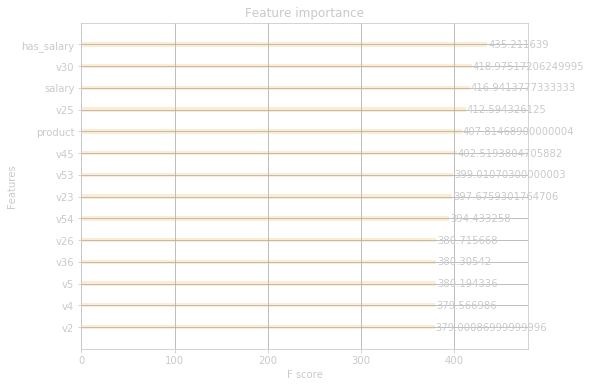

In [60]:
xgb.plot_importance(estimator, importance_type="cover")

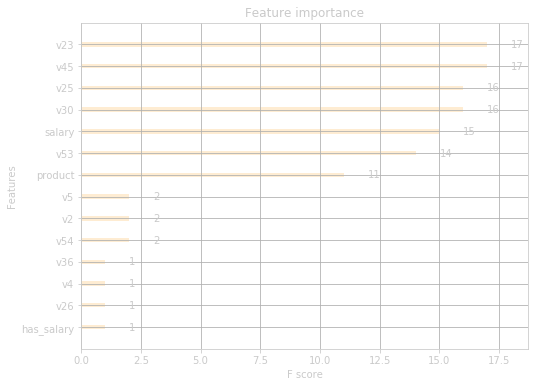

In [61]:
xgb.plot_importance(estimator, importance_type="weight")

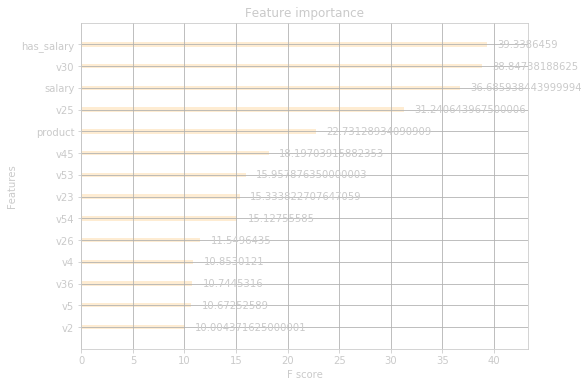

In [62]:
xgb.plot_importance(estimator, importance_type="gain")

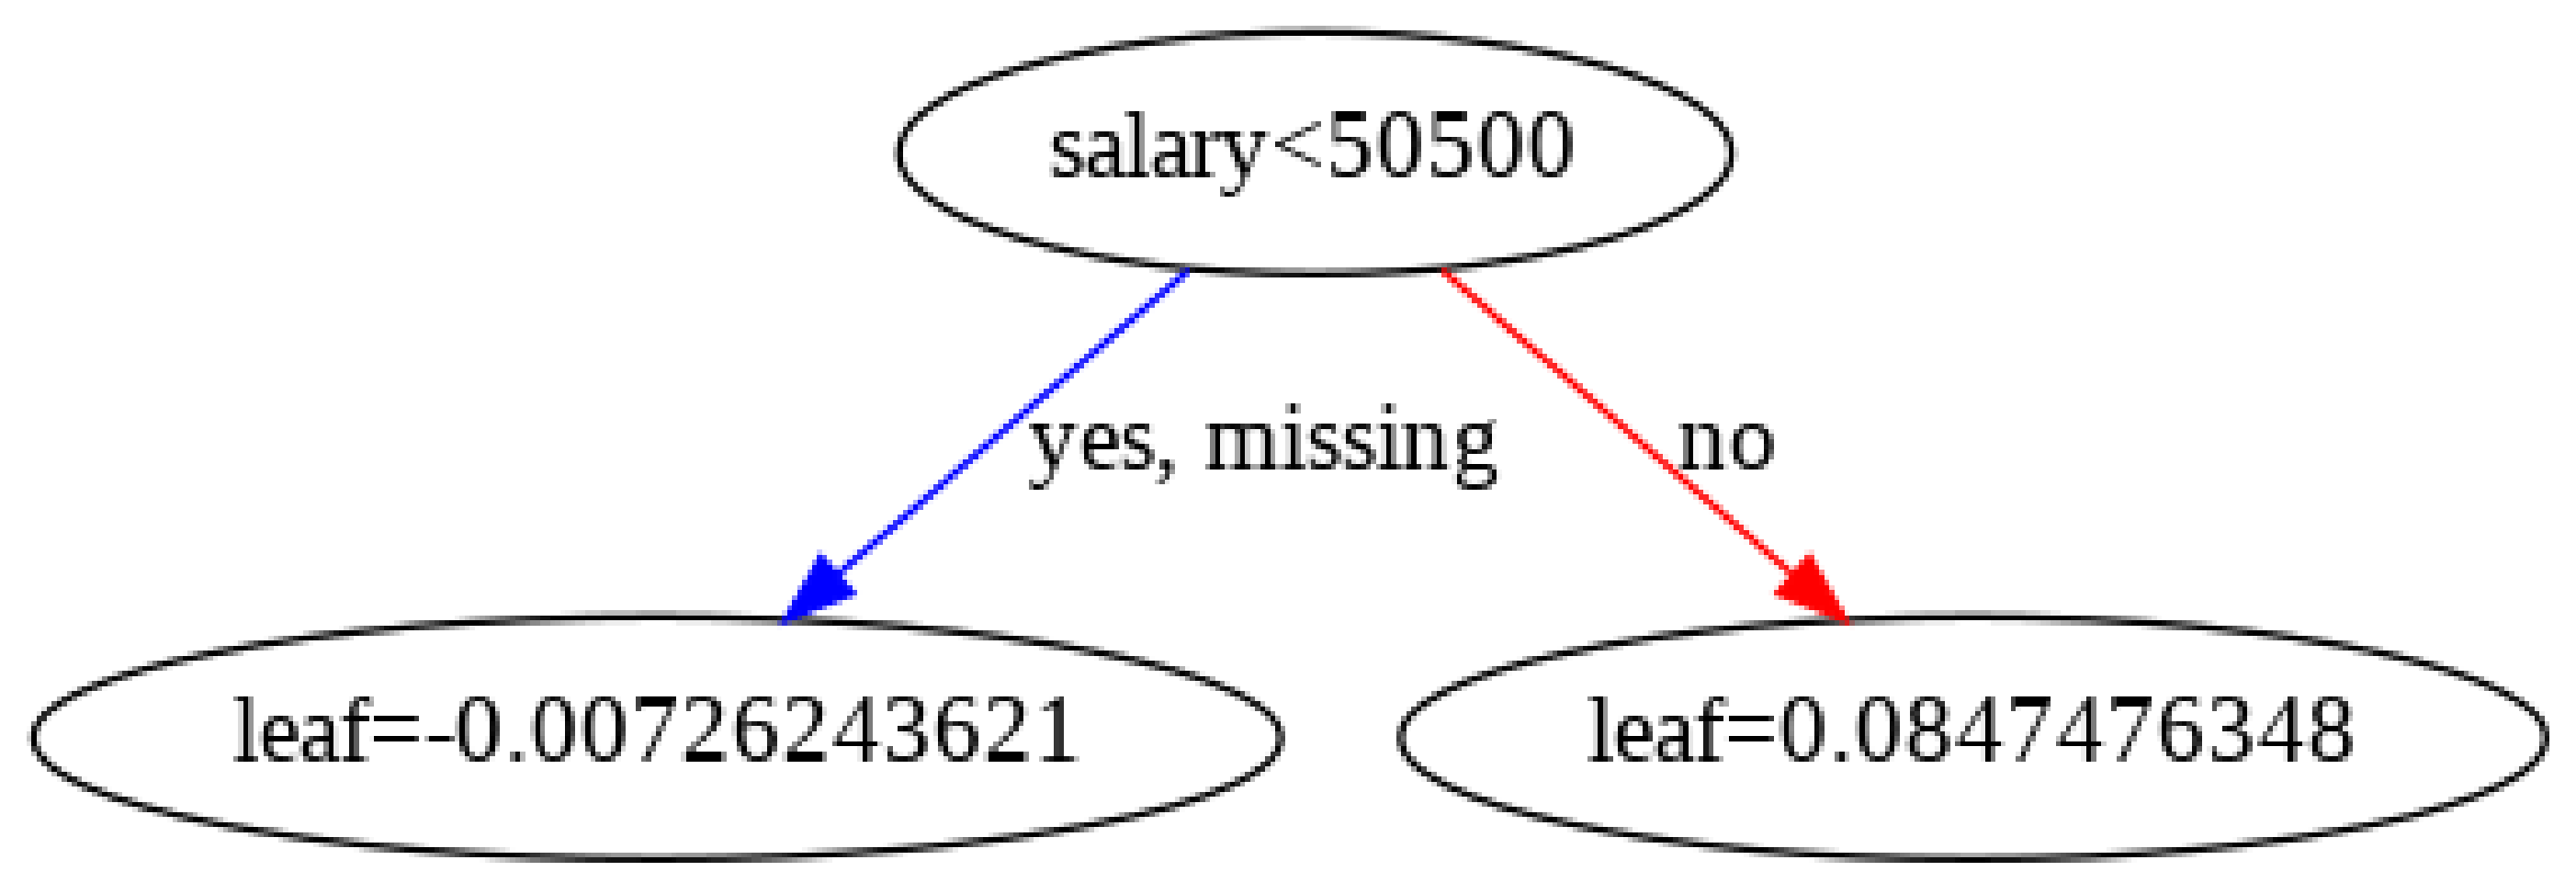

In [91]:
plt.rcParams["figure.figsize"] = (50, 40)
xgb.plot_tree(estimator, num_trees=3)
plt.savefig('tree.svg', transparent=True)

In [127]:
explainer = shap.TreeExplainer(estimator)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


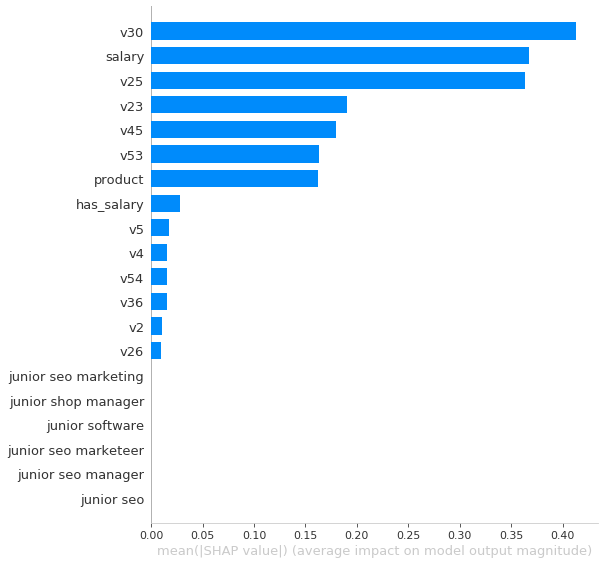

In [128]:
shap.summary_plot(shap_values, X, plot_type="bar")

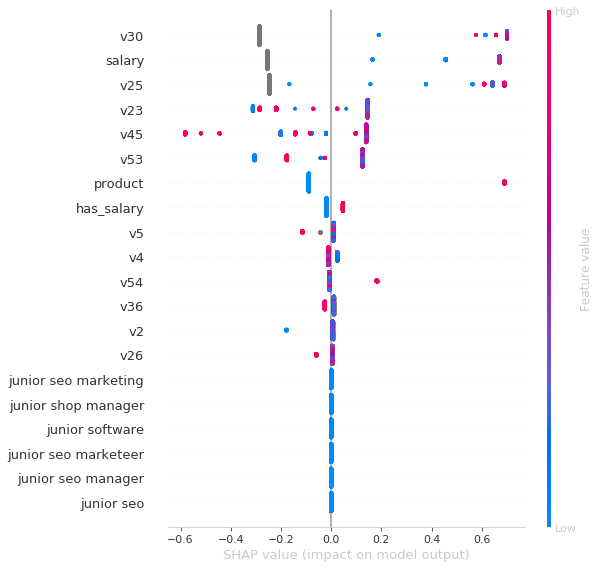

In [131]:
shap.summary_plot(shap_values, X, show=False)
plt.savefig('explain_complex.svg', transparent=True)

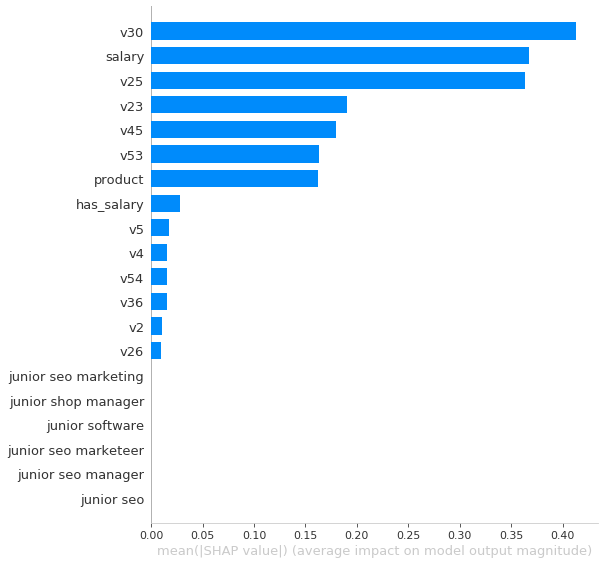

In [132]:
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.savefig('explain_bar.svg', transparent=True)

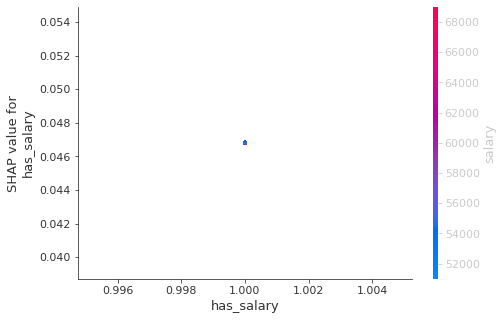

In [67]:
shap.dependence_plot("has_salary", shap_values, X)

# Broader Model

Now the previous model is great for microtargetting participants, but what about general appeal? What can one do to make more broad claims about how to write a job offer?

For that, let's take user data out of the equation and see what we can get.

In [68]:
usercolumns
X.columns

Index(['affairs', 'affairs apac', 'affairs france', 'affairs new',
       'affairs new ventures', 'ai', 'ai researcher', 'ai researcher deep',
       'ai researcher nlp', 'ai researcher pricing',
       ...
       'company_g', 'company_h', 'has_mfd', 'count_spaces', 'avg_word_length',
       'avg_sentence_length', 'count_digits', 'count_slashes', 'count_paren',
       'char_length_title'],
      dtype='object', length=541)

In [69]:
X_general = X[X.columns[~X.columns.isin(usercolumns)]]

In [70]:
y.describe()

count    2000.000000
mean        0.576000
std         0.494314
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: has_applied, dtype: float64

In [116]:
X_general_train, X_general_test, y_general_train, y_general_test = split(df_general)

In [117]:
%%time

## Learning on all data
param_test = {
 'max_depth':[1,2,3],
 'min_child_weight':[8]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( 
        learning_rate = 0.1,
        n_estimators=140,
        max_depth=6,
        min_child_weight=8,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.9,
        objective = 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 0.1,
        seed=23),
       param_grid = param_test, scoring='roc_auc',n_jobs=4,verbose=10, cv=5)
gsearch5.fit(X_general_train, y_general_train)
gsearch5.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:    7.3s remaining:    3.7s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:    8.6s remaining:    2.2s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:   10.8s finished


CPU times: user 1.17 s, sys: 88.7 ms, total: 1.26 s
Wall time: 11.5 s


({'max_depth': 1, 'min_child_weight': 8}, 0.7885604907257475)

In [118]:
result = gsearch5.predict(X_general_test)
fpr, tpr, thresholds = metrics.roc_curve(y_general_test, result)
metrics.auc(fpr, tpr)

0.5756067408419546

In [71]:
%%time

## Learning on all data
param_test = {
 'max_depth':[1],
 'min_child_weight':[8]
}
gsearch5 = GridSearchCV(estimator = xgb.XGBClassifier( 
        learning_rate = 0.1,
        n_estimators=140,
        max_depth=6,
        min_child_weight=8,
        gamma=0,
        subsample=0.9,
        colsample_bytree=0.9,
        objective = 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        reg_alpha = 0.1,
        seed=23),
       param_grid = param_test, scoring='roc_auc',n_jobs=4,verbose=10, cv=5)
gsearch5.fit(X_general, y)
gsearch5.best_params_, gsearch4.best_score_

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    2.9s remaining:    4.3s
[Parallel(n_jobs=4)]: Done   3 out of   5 | elapsed:    2.9s remaining:    1.9s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    3.7s finished


CPU times: user 1.44 s, sys: 79.1 ms, total: 1.52 s
Wall time: 4.56 s


({'max_depth': 1, 'min_child_weight': 8}, 0.7885604907257475)

In [72]:
estimator2 = gsearch5.best_estimator_

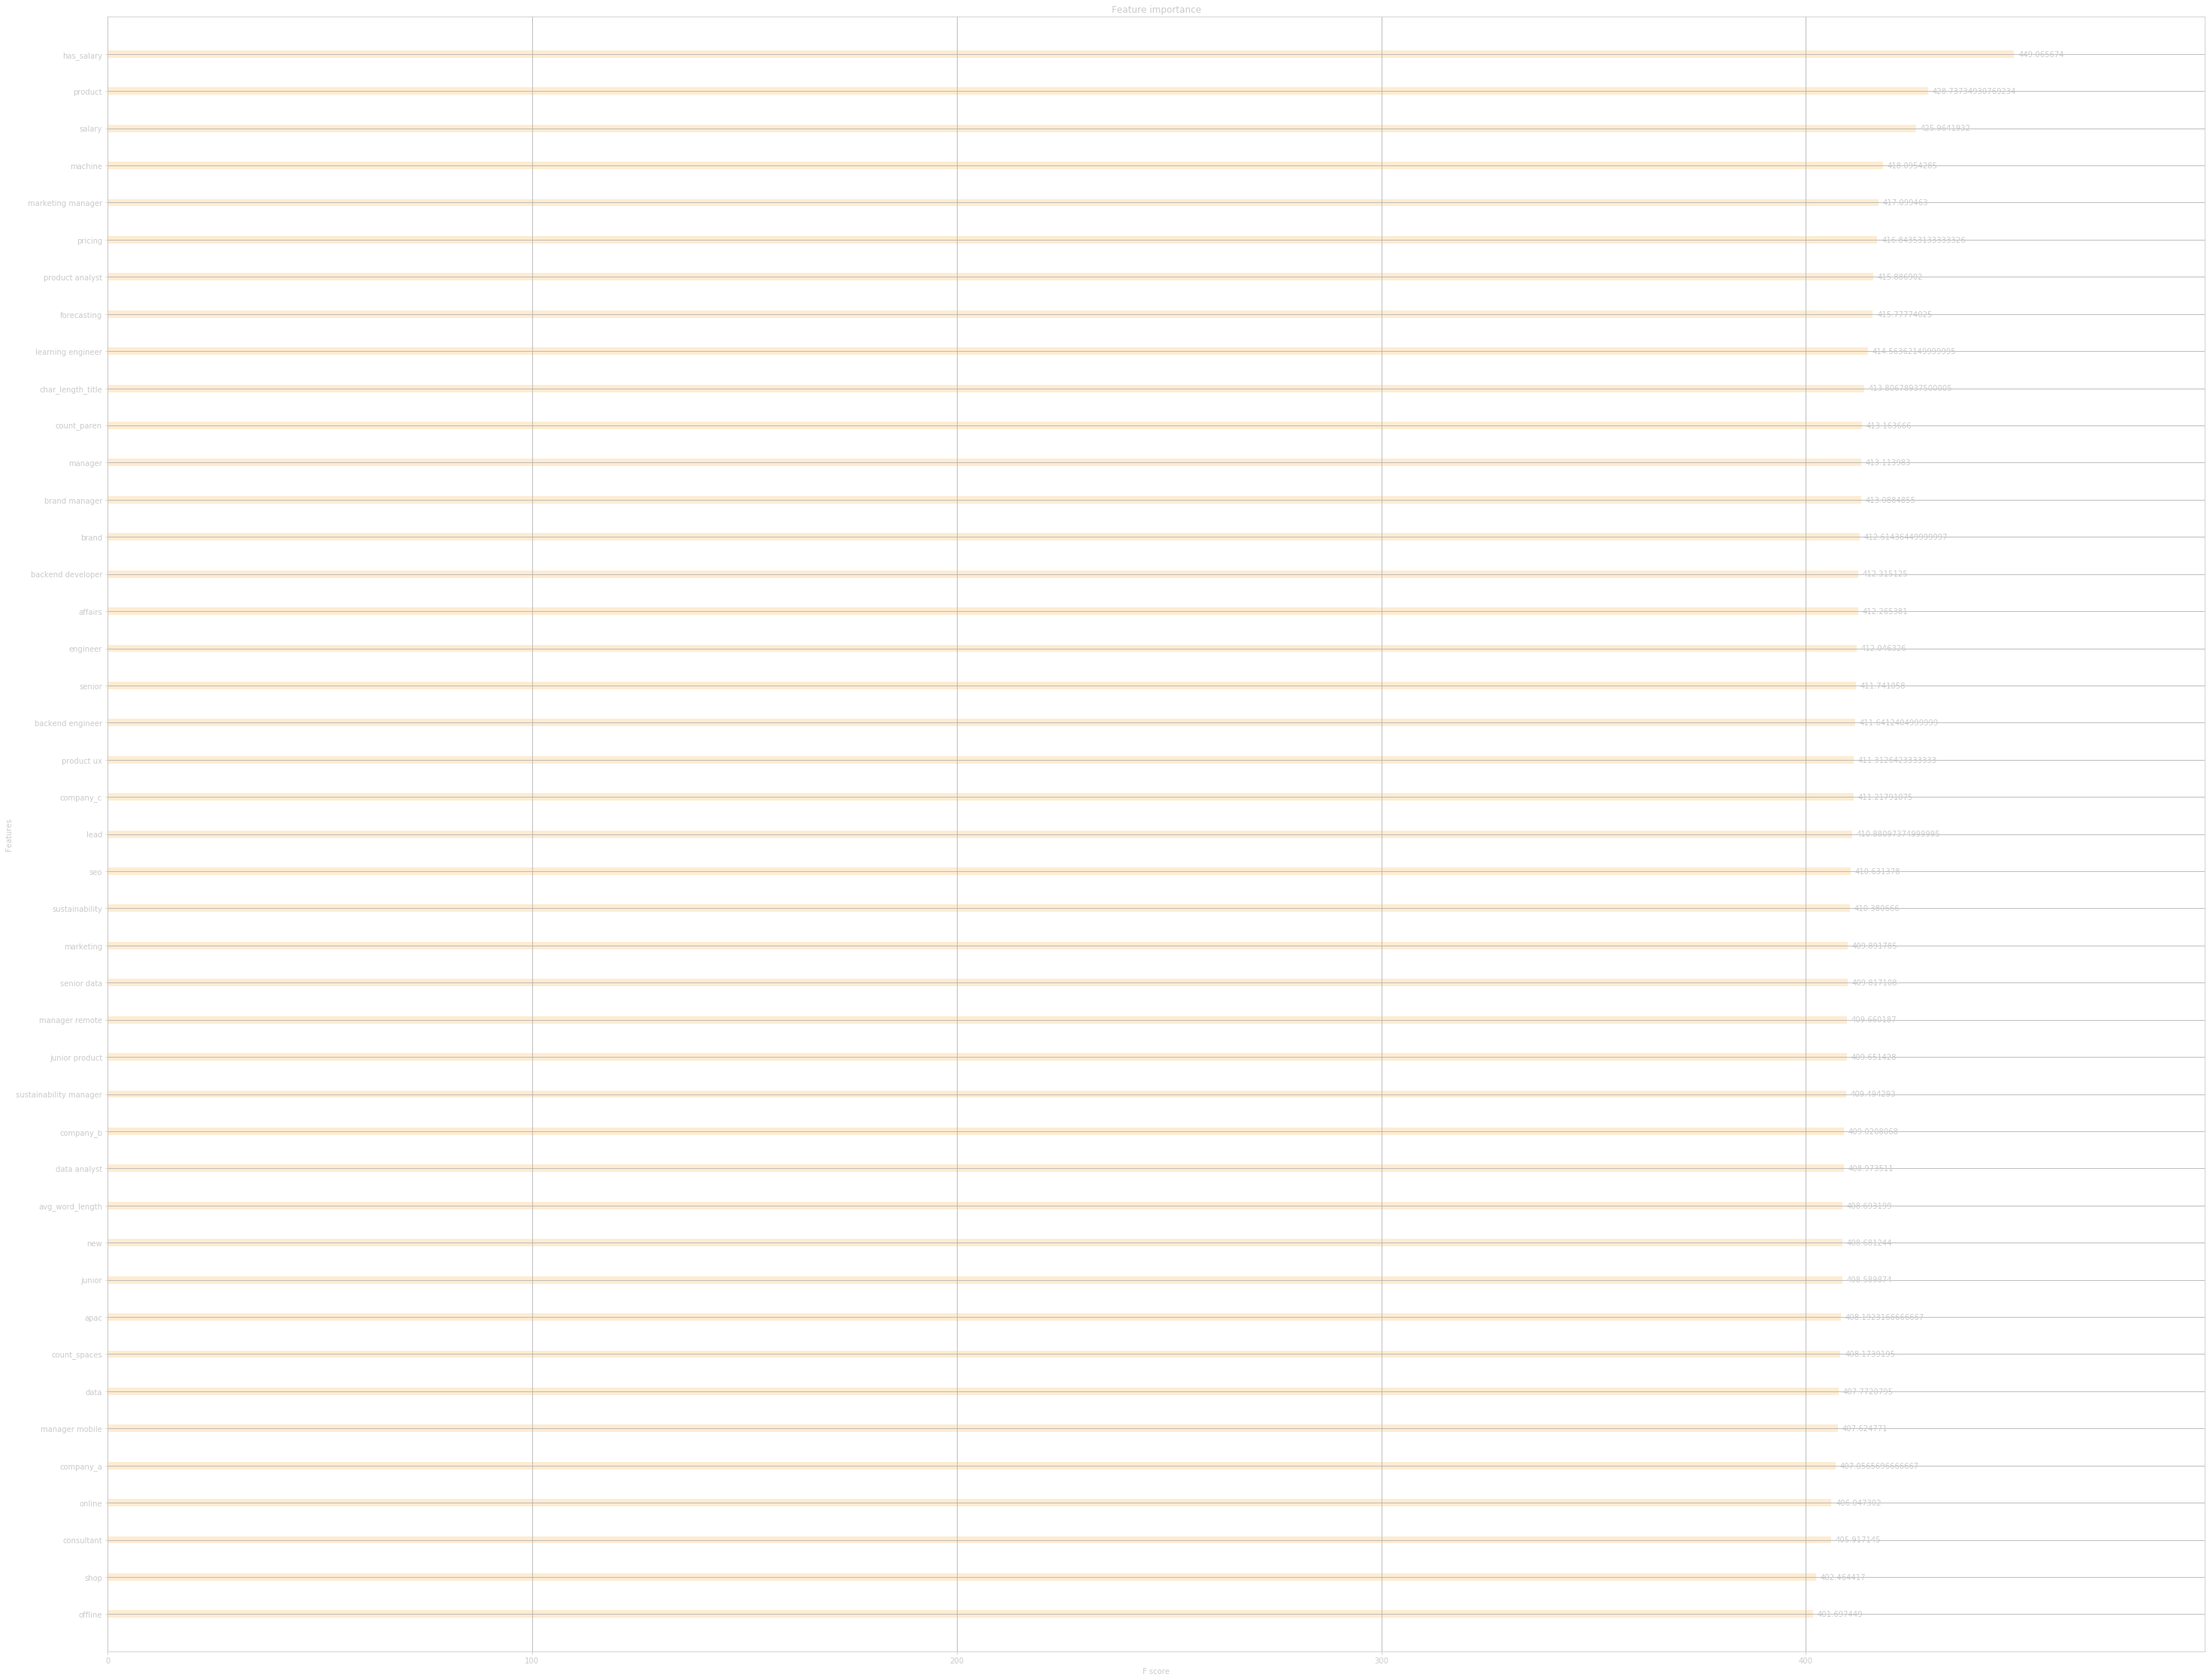

In [73]:
xgb.plot_importance(estimator2, importance_type="cover")

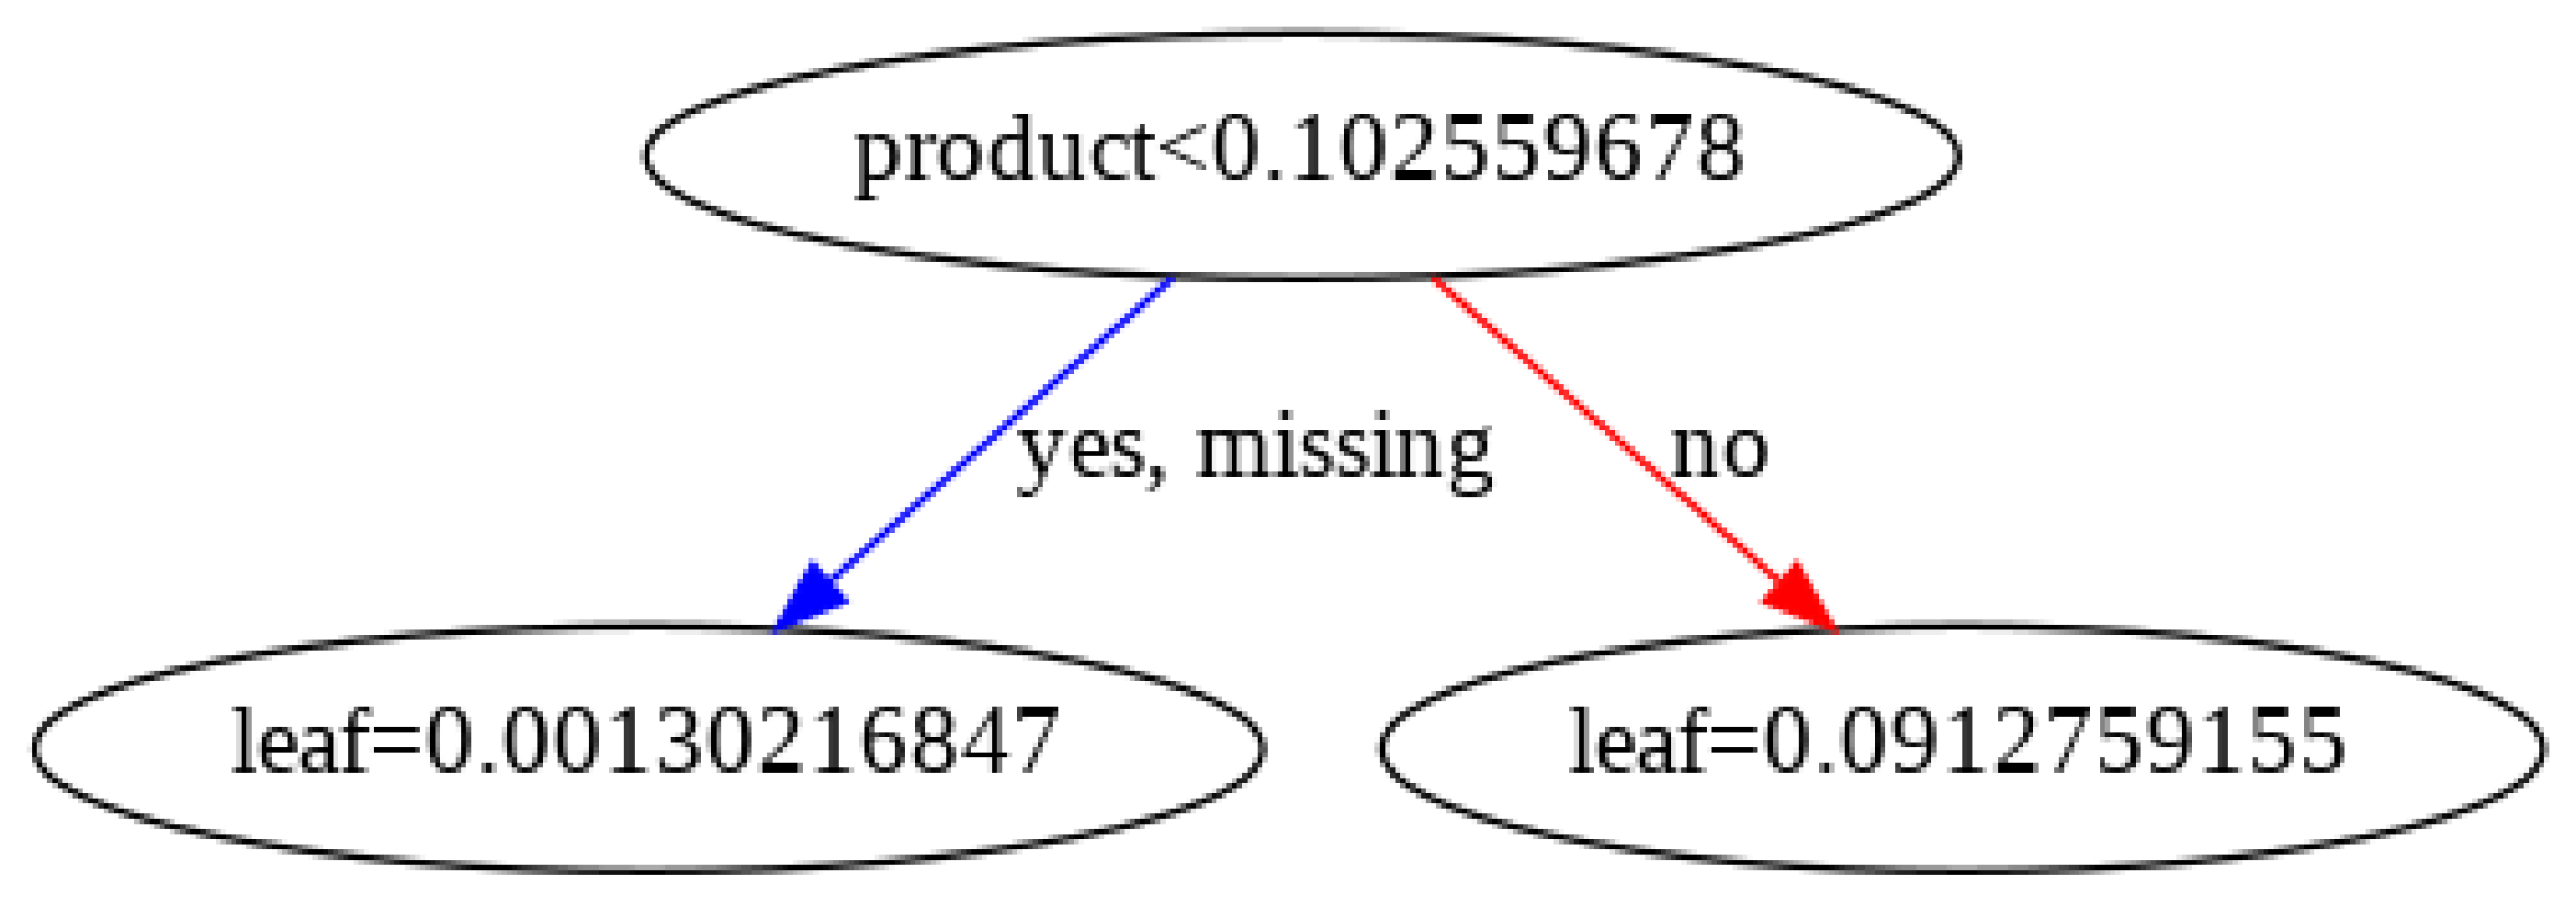

In [105]:
plt.rcParams["figure.figsize"] = (50, 40)
xgb.plot_tree(estimator2, num_trees=7)
plt.savefig('tree.svg', transparent=True)

In [74]:
df_general = X_general.join(y)

In [135]:

explainer = shap.TreeExplainer(estimator2)
shap_values = explainer.shap_values(X_general)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_general.iloc[0,:])

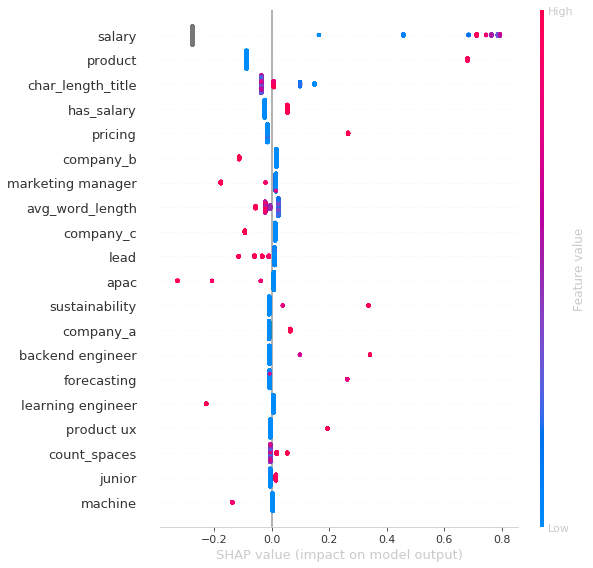

In [136]:
shap.summary_plot(shap_values, X_general, show=False)
plt.savefig('explain_complex_general.svg', transparent=True)

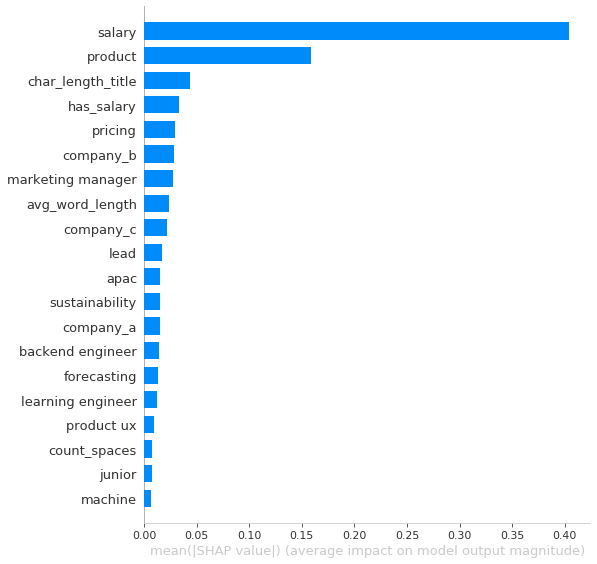

In [137]:
shap.summary_plot(shap_values, X_general, plot_type="bar", show=False)
plt.savefig('explain_bar_general.svg', transparent=True)

invalid value encountered in true_divide
invalid value encountered in true_divide


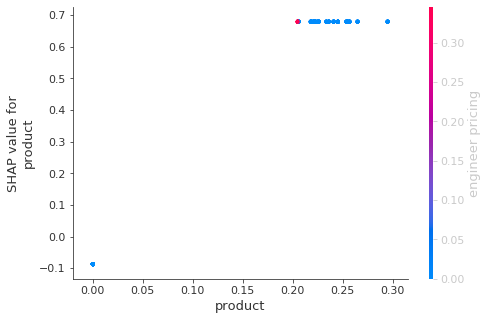

In [138]:
shap.dependence_plot("product", shap_values, X_general)

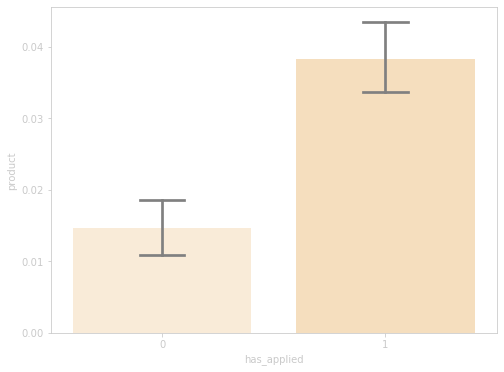

In [157]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.barplot(x=df_general["has_applied"], y=df_general["product"], capsize=.2, errcolor='grey')
plt.savefig('product.svg', transparent=True)

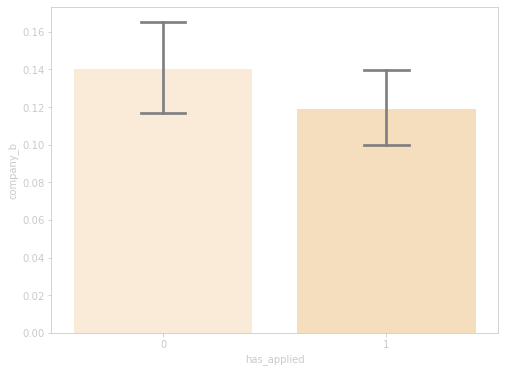

In [152]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.barplot(x=df_general["has_applied"], y=df_general["product"], capsize=.2, errcolor='grey')
plt.savefig('product.svg', transparent=True)

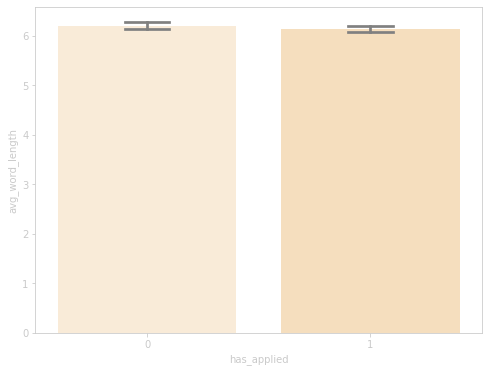

In [153]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.barplot(x=df_general["has_applied"], y=df_general["avg_word_length"], capsize=.2, errcolor='grey')
plt.savefig('word_length.svg', transparent=True)

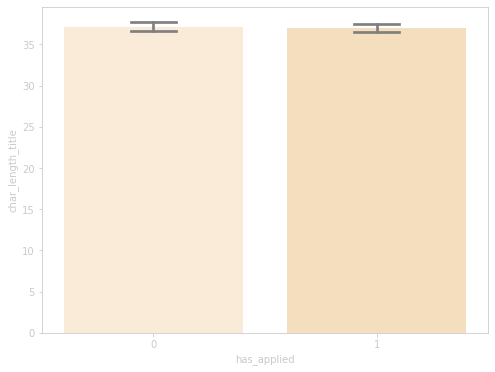

In [158]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.barplot(x=df_general["has_applied"], y=df_general["char_length_title"], capsize=.2, errcolor='grey')
plt.savefig('char_title.svg', transparent=True)

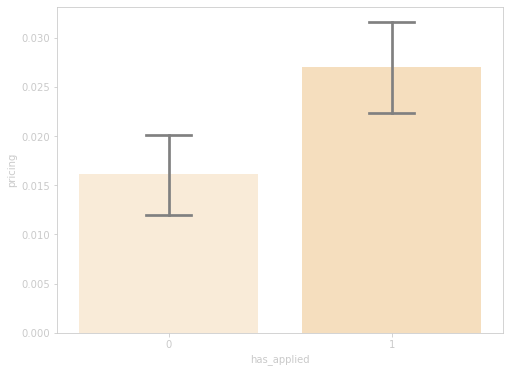

In [156]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.barplot(x=df_general["has_applied"], y=df_general["pricing"], capsize=.2, errcolor='grey')
plt.savefig('pricing.svg', transparent=True)

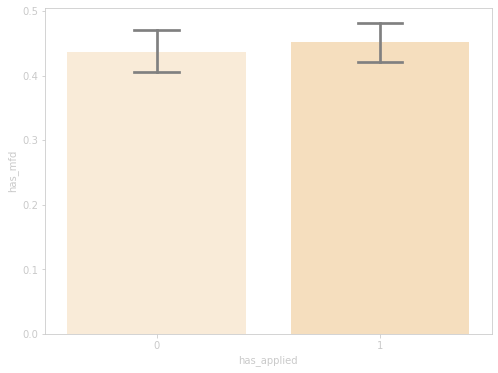

In [166]:
plt.rcParams["figure.figsize"] = (8, 6)
sns.barplot(x=df_general["has_applied"], y=df_general["has_mfd"], capsize=.2, errcolor='grey')
plt.savefig('pricing.svg', transparent=True)

In [78]:
pd.set_option('display.max_rows', None)
df_general[df_general.columns[1:]].corr()['has_applied'][:].sort_values(ascending=True)

learning engineer                -0.059839
machine                          -0.059839
machine learning engineer        -0.059839
machine learning                 -0.059839
analyst remote                   -0.051544
senior operations manager        -0.051251
senior operations                -0.051251
operations manager apac          -0.051251
shop manager new                 -0.049254
lead growth marketing            -0.048131
lead machine                     -0.046795
learning engineer remote         -0.046795
lead machine learning            -0.046795
engineer supplier                -0.045637
learning engineer supplier       -0.045637
junior machine learning          -0.045637
junior machine                   -0.045637
engineer supplier financing      -0.045637
ventures                         -0.044034
new ventures                     -0.044034
new                              -0.044034
lead shop                        -0.042686
lead shop manager                -0.042686
apac       

In [79]:
pd.crosstab(df_general['has_applied'], df_general['product'], normalize=True)

product      0.000000  0.205119  0.205194  0.205954  0.218097  0.218919  \
has_applied                                                               
0               0.398     0.001    0.0005    0.0010     0.001    0.0020   
1               0.481     0.006    0.0065    0.0055     0.005    0.0025   

product      0.221083  0.221604  0.222007  0.222978  ...  0.226067  0.233705  \
has_applied                                          ...                       
0              0.0015    0.0005    0.0005    0.0020  ...    0.0005    0.0010   
1              0.0060    0.0020    0.0045    0.0025  ...    0.0045    0.0035   

product      0.236118  0.240973  0.245281  0.253808  0.254421  0.256701  \
has_applied                                                               
0              0.0005     0.002     0.001    0.0025    0.0020     0.002   
1              0.0055     0.005     0.010    0.0035    0.0045     0.006   

product      0.264927  0.295006  
has_applied                      
0              0.0005    0.0025  
1              0.0040    0.0030  

[2 rows x 21 columns]

In [80]:
df_cleaned.corr()['has_applied'][:].sort_values(ascending=True)

v5                    -0.048911
v36                   -0.039258
v8                    -0.039097
company_c             -0.038835
avg_word_length       -0.036049
company_b             -0.031665
v11                   -0.030218
v4                    -0.024490
v49                   -0.023800
v50                   -0.022963
v45                   -0.022443
v51                   -0.022068
v47                   -0.021579
v55                   -0.021517
v37                   -0.021481
v9                    -0.020220
v29                   -0.020138
company_f             -0.017547
v10                   -0.017162
v16                   -0.015920
v23                   -0.014567
v34                   -0.013680
v41                   -0.011648
v39                   -0.011437
char_length_title     -0.010190
v52                   -0.009269
v28                   -0.007610
v40                   -0.006598
v32                   -0.005326
v14                   -0.004660
v44                   -0.003564
v2      

In [81]:
df_cleaned.columns

Index(['has_applied', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16',
       'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25',
       'v26', 'v27', 'v28', 'v29', 'v3', 'v30', 'v31', 'v32', 'v33', 'v34',
       'v35', 'v36', 'v37', 'v38', 'v39', 'v4', 'v40', 'v41', 'v42', 'v43',
       'v44', 'v45', 'v46', 'v47', 'v48', 'v49', 'v5', 'v50', 'v51', 'v52',
       'v53', 'v54', 'v55', 'v56', 'v6', 'v7', 'v8', 'v9', 'job_title_full',
       'salary', 'has_salary', 'company_a', 'company_b', 'company_c',
       'company_d', 'company_e', 'company_f', 'company_g', 'company_h',
       'has_mfd', 'count_spaces', 'avg_word_length', 'avg_sentence_length',
       'count_digits', 'count_slashes', 'count_paren', 'char_length_title'],
      dtype='object')